In [1]:
!pip install allennlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.2/730.2 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 kB 13.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 35.1 MB/s eta 0:00:00
  Preparing metadat

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import random
import time
import datetime
import json
import pandas as pd
import numpy as np
import torch
import pickle
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import f1_score
import copy

In [4]:
# Load the config file
def load_config(config_path):
    # Load and parse the config file
    with open(config_path, 'r') as f:
        config = json.load(f)

    return config

config = load_config('./HBiLSTM_CL.json')

In [5]:
from data import SequenceClassificationDataset

In [6]:
root = '/content/'
cl_train_dataset = SequenceClassificationDataset(Path(root, 'train_scibert.json'))
cl_dev_dataset = SequenceClassificationDataset(Path(root, 'dev_scibert.json'))
cl_test_dataset = SequenceClassificationDataset(Path(root, 'test_scibert.json'))

In [7]:
len(cl_train_dataset)

40

In [8]:
batch_size=1
train_dataloader = DataLoader(cl_train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(cl_dev_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(cl_test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
for batch in train_dataloader:
  print(len(batch))
  break

4


In [10]:
batch.keys()

dict_keys(['input_ids', 'label_ids', 'attention_mask', 'sentence_masks'])

In [11]:
batch['input_ids'].shape

AttributeError: ignored

In [75]:
from models import BertHSLN

In [76]:
BERT_MODEL = "bert-base-uncased"
mconfig = {
    "bert_model": BERT_MODEL,
    "bert_trainable": False,
    "model": BertHSLN.__name__,
    "cacheable_tasks": [],

    "dropout": 0.5,
    "word_lstm_hs": 384,
    "att_pooling_dim_ctx": 100,
    "att_pooling_num_ctx": 7,

    "lr": 3e-05,
    "lr_epoch_decay": 0.9,
    "batch_size":  32,
    "max_seq_length": 120,
    "max_epochs": 20,
    "early_stopping": 20,

}

In [77]:
torch.cuda.is_available()

True

In [78]:
# assign device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device used: {device}")

device used: cuda


In [79]:
model = BertHSLN(mconfig, num_labels = 7)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Attention pooling dim: 5376


In [80]:
lr = mconfig['lr']#config['training']['learning_rate']
'''max_grad_norm = config['training']['max_grad_norm']
epochs = config['training']['epochs']

num_total_steps = len(train_dataloader)*epochs
num_warmup_steps = config['training']['num_warmup_steps']
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  # 0.1
'''
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=True)
#epoch_scheduler = StepLR(optimizer, step_size=1, gamma=config['training']["lr_epoch_decay"])

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = num_total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [81]:
from torch.optim.lr_scheduler import StepLR
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=lr)
epoch_scheduler = StepLR(optimizer, step_size=1, gamma=mconfig["lr_epoch_decay"])


In [82]:
seed_val = config['training']['seed']
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [83]:
# assign device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device used: {device}")
model.to(device)

device used: cuda


BertHSLN(
  (bert): BertTokenEmbedder(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
               

In [84]:
import functools
import operator

In [85]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

21328998

In [86]:
from allennlp.common.util import pad_sequence_to_length

def batch_to_tensor(b):
    # convert to dictionary of tensors and pad the tensors
    max_sentence_len = 128
    result = {}
    for k, v in b.items():

        if k in ["input_ids", "attention_mask"]:
            # determine the max sentence len in the batch
            max_sentence_len = -1
            for sentence in v:
                sentence = torch.cat(sentence)
                max_sentence_len = max(len(sentence), max_sentence_len)
            # pad the sentences to max sentence len
            for i, sentence in enumerate(v):
                v[i] = pad_sequence_to_length(sentence, desired_length=max_sentence_len)
        if k!='doc_name' and k!= 'label_ids':
            result[k] = torch.tensor(v).unsqueeze(0)
        elif k == 'label_ids':
            result[k] = torch.tensor(v)
        else:
            result[k] = v
    return result


In [87]:
def training_step(model, criterion, optimizer, scheduler, data_loader):
    model.train()  # Set the model to train mode
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    all_labels = []
    all_predicted = []

    for batch in data_loader:
        batch = batch_to_tensor(batch)
        for key, tensor in batch.items():
            batch[key] = tensor.to(device)
        labels = batch['label_ids']

        optimizer.zero_grad()

        # Forward pass
        output = model(batch, labels)


        #max_sequence_length = output.size(1)
        #tlengths = torch.tensor(lengths).unsqueeze(1)
        #mask = torch.arange(max_sequence_length).unsqueeze(0).to(device) < tlengths
        #masked_output = output['predicted_label']

        # Calculate loss
        #loss = criterion(masked_output, labels)
        loss = output['loss']
        train_loss += loss.item()

        # Calculate accuracy
        #predicted_labels = masked_output.argmax(dim=-1)
        #correct = (predicted_labels == labels).sum().item()
        #train_correct += correct
        #train_total += labels.shape[0]

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # save all epoch labels and predicted labels
        #all_labels.extend(labels.cpu())
        #all_predicted.extend(predicted_labels.cpu())
    epoch_scheduler.step()
    # Calculate epoch statistics
    train_loss /= len(data_loader)
    #train_accuracy = train_correct / train_total
    # calculate f1
    #f1 = f1_score(all_labels, all_predicted, average='weighted')
    return train_loss#, train_accuracy, f1


def validation_step(model, criterion, data_loader):
    model.eval()  # Set the model to evaluation mode
    dev_loss = 0.0
    dev_correct = 0
    dev_total = 0
    all_labels = []
    all_predicted = []


    for batch in data_loader:
        with torch.no_grad():
            batch = batch_to_tensor(batch)
            for key, tensor in batch.items():
               batch[key] = tensor.to(device)
            labels = batch['label_ids']
            # Forward pass
            outputs = model(batch)
            #max_sequence_length = outputs.size(1)
            #tlengths = torch.tensor(lengths).unsqueeze(1)
            #mask = torch.arange(max_sequence_length).unsqueeze(0).to(device) < tlengths
            #masked_output = output['predicted_label']

            # Calculate loss
            #loss = criterion(masked_output, labels)
            predicted_label = outputs['predicted_label']
            #dev_loss += loss.item()

            # Calculate accuracy
            #predicted_labels = masked_output.argmax(dim=-1)
            #correct = (predicted_labels == labels).sum().item()
            #dev_correct += correct
            #dev_total += labels.shape[0]

            # save all epoch labels and predicted labels
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted_label.cpu().numpy())

    # Calculate epoch statistics
    #dev_loss /= len(data_loader)
    #dev_accuracy = dev_correct / dev_total
    # calculate f1
    all_predicted = functools.reduce(operator.iconcat, all_predicted, [])
    all_labels = functools.reduce(operator.iconcat, all_labels, [])
    print(len(all_predicted), len(all_labels))
    f1 = f1_score(all_labels, all_predicted, average='weighted')
    return f1


In [88]:
train_epoch_losses = []
train_epoch_acc = []
train_epoch_f1 = []

dev_epoch_losses = []
dev_epoch_acc = []
dev_epoch_f1 = []


best_dev_f1 = 0
best_model = None


# Training loop
for epoch in range(epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))

    # Training
    train_loss = training_step(model, criterion, optimizer, scheduler, train_dataloader)
    train_epoch_losses.append(train_loss)
    #train_epoch_acc.append(train_accuracy)
    #train_epoch_f1.append(train_f1)
    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f}")

    # Validation
    dev_f1 = validation_step(model, criterion, valid_dataloader)
    #dev_epoch_losses.append(dev_loss)
    #dev_epoch_acc.append(dev_accuracy)
    dev_epoch_f1.append(dev_f1)
    print(f"Epoch {epoch+1}/{epochs} - F1 {dev_f1}")

    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        best_model = copy.deepcopy(model)

======== Epoch 1 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 1/300 - Training Loss: 563.1874
1394 1394
Epoch 1/300 - F1 0.10956163280252004
======== Epoch 2 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 2/300 - Training Loss: 526.7592
1394 1394
Epoch 2/300 - F1 0.11063654436120131
======== Epoch 3 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 3/300 - Training Loss: 511.9383
1394 1394
Epoch 3/300 - F1 0.15662307402021475
======== Epoch 4 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 4/300 - Training Loss: 484.5358
1394 1394
Epoch 4/300 - F1 0.1869356858246673
======== Epoch 5 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 5/300 - Training Loss: 465.3927
1394 1394
Epoch 5/300 - F1 0.31807713936954973
======== Epoch 6 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 6/300 - Training Loss: 458.5605
1394 1394
Epoch 6/300 - F1 0.38951293019976124
======== Epoch 7 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 7/300 - Training Loss: 444.6204
1394 1394
Epoch 7/300 - F1 0.33366829614635896
======== Epoch 8 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 8/300 - Training Loss: 440.9730
1394 1394
Epoch 8/300 - F1 0.36585451637265604
======== Epoch 9 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 9/300 - Training Loss: 427.3885
1394 1394
Epoch 9/300 - F1 0.4125277350524367
======== Epoch 10 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 10/300 - Training Loss: 424.5659
1394 1394
Epoch 10/300 - F1 0.3602111970443652
======== Epoch 11 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 11/300 - Training Loss: 421.7942
1394 1394
Epoch 11/300 - F1 0.4235958319186464
======== Epoch 12 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 12/300 - Training Loss: 411.1661
1394 1394
Epoch 12/300 - F1 0.3955682677498254
======== Epoch 13 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 13/300 - Training Loss: 404.9735
1394 1394
Epoch 13/300 - F1 0.39619595544865643
======== Epoch 14 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 14/300 - Training Loss: 395.3669
1394 1394
Epoch 14/300 - F1 0.41982814284658904
======== Epoch 15 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 15/300 - Training Loss: 395.0020
1394 1394
Epoch 15/300 - F1 0.41522763838777543
======== Epoch 16 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 16/300 - Training Loss: 392.1894
1394 1394
Epoch 16/300 - F1 0.42569990609184616
======== Epoch 17 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 17/300 - Training Loss: 383.3941
1394 1394
Epoch 17/300 - F1 0.43267259475598113
======== Epoch 18 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 18/300 - Training Loss: 380.1653
1394 1394
Epoch 18/300 - F1 0.4366404721801315
======== Epoch 19 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 19/300 - Training Loss: 375.0520
1394 1394
Epoch 19/300 - F1 0.4115739403731627
======== Epoch 20 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Epoch 20/300 - Training Loss: 372.8495
1394 1394
Epoch 20/300 - F1 0.43048099662055306
======== Epoch 21 / 300 ========


<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


KeyboardInterrupt: ignored

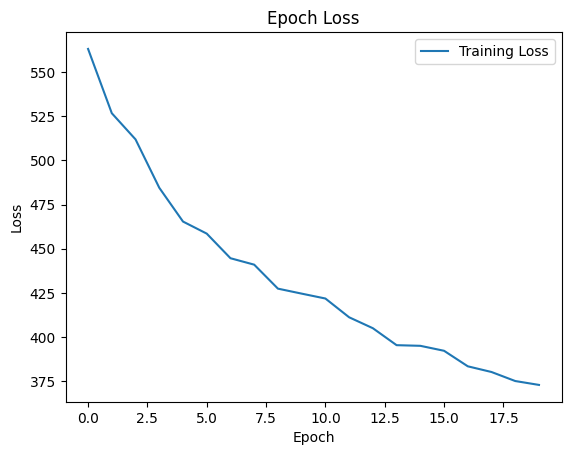

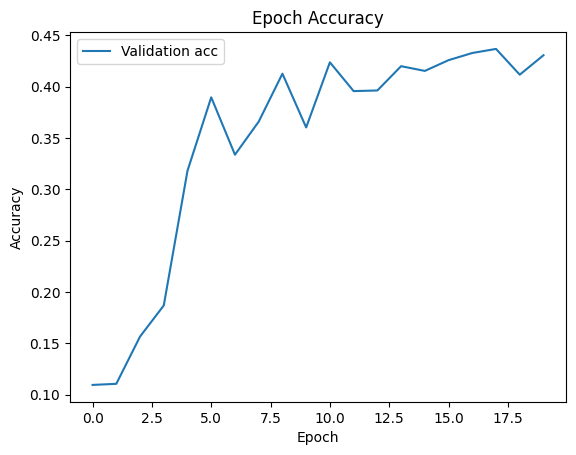

In [89]:
import matplotlib.pyplot as plt

# Plot the epoch loss
plt.plot(train_epoch_losses, label='Training Loss')
#plt.plot(dev_epoch_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Epoch Loss')
plt.show()

# Plot the epoch accuracies
#plt.plot(train_epoch_acc, label='Training acc')
plt.plot(dev_epoch_f1, label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Epoch Accuracy')
plt.show()

In [100]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [113]:
from sklearn.metrics import classification_report

def testing_step(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    model.to(device)

    for batch in data_loader:
        with torch.no_grad():

            batch = batch_to_tensor(batch)
            for key, tensor in batch.items():
               batch[key] = tensor.to(device)
            labels = batch['label_ids']
            # Forward pass
            outputs = model(batch)
            #max_sequence_length = outputs.size(1)
            #tlengths = torch.tensor(lengths).unsqueeze(1)
            #mask = torch.arange(max_sequence_length).unsqueeze(0).to(device) < tlengths
            #masked_output = outputs[mask]
            predicted_labels = outputs['predicted_label']

            # Calculate loss
            #loss = criterion(masked_output, labels)
            #test_loss += loss.item()

            # Store predictions and true labels
            #predicted_labels = masked_output.argmax(dim=-1)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Calculate accuracy
            predicted_labels.detach().cpu().numpy()
            labels = labels.to('cpu')

            correct = (predicted_labels == labels).sum().item()
            test_correct += correct
            test_total += labels.shape[0]

    predictions = functools.reduce(operator.iconcat, predictions, [])
    true_labels = functools.reduce(operator.iconcat, true_labels, [])

    test_loss /= len(data_loader)
    test_accuracy = test_correct / test_total

    print(f"Testing Loss: {test_loss:.4f} - Testing Accuracy: {test_accuracy:.4f}")
    print(classification_report(true_labels, predictions))
    return test_loss, test_accuracy, predictions, true_labels

In [114]:
# Testing loop
test_loss, test_accuracy, predictions, true_labels = testing_step(model, test_dataloader, criterion)

<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
Testing Loss: 0.0000 - Testing Accuracy: 170.8000
              precision    recall  f1-score   support

           0       0.63      0.62      0.62       326
           1       0.90      0.72      0.80       201
           2       0.67      0.28      0.40       256
           3       0.55      0.85      0.67       434
           4       0.00      0.00      0.00        23
           5       0.71      0.42      0.53        12
           6       0.84      0.71      0.77        86

    accuracy                           0.64      1338
   macro avg       0.61      0.51      0.54      1338
weighted avg       0.66      0.64      0.62      1338



In [115]:
# Testing loop
test_loss, test_accuracy, predictions, true_labels = testing_step(best_model, test_dataloader, criterion)

<ipython-input-86-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
Testing Loss: 0.0000 - Testing Accuracy: 169.8000
              precision    recall  f1-score   support

           0       0.60      0.63      0.62       326
           1       0.80      0.72      0.76       201
           2       0.72      0.29      0.42       256
           3       0.57      0.83      0.67       434
           4       0.00      0.00      0.00        23
           5       0.71      0.42      0.53        12
           6       0.87      0.67      0.76        86

    accuracy                           0.63      1338
   macro avg       0.61      0.51      0.54      1338
weighted avg       0.65      0.63      0.62      1338

